In [109]:
!pip install gym==0.21.0
!pip install stable_baselines3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [110]:
# Imports
import random
import gym
from gym import spaces
import pandas as pd
import numpy as np
import math

# Utiliy funcitons
def sigmoid(x, steepness = 1):
  return 1 / (1 + math.exp(-x * steepness))

def customSigmoid(x, a, b, c, d):
    """ General sigmoid function
    a adjusts amplitude
    b adjusts y offset
    c adjusts x offset
    d adjusts slope """
    y = ((a-b) / (1 + np.exp(x-(c/2))**d)) + b
    return y


def likeness_to_buy(x, discount_days, total_days, normal_price, reduced_price):
  return max(customSigmoid(x, 1, 0.25, total_days, -1), customSigmoid(x, 4*(1 - reduced_price / normal_price), 0, 0, -1) if x <= discount_days else 0)


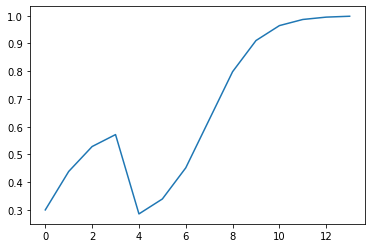

In [111]:
import matplotlib.pyplot as plt

x = np.arange(14)
plt.plot(x, [likeness_to_buy(x_val, 3, 14, 250, 250 - 250*0.15) for x_val in x])
#plt.plot(x, [likeness_to_buy(x_val, 3, 14, 250, 250 - 250*0.0) for x_val in x])



In [112]:
# from https://www.gymlibrary.dev/content/environment_creation/
# Our environment inlcudes one product which has different expiration times left
INITIAL_NUMBER_OF_PRODUCTS = 500
PRICE_RECOMMENDATION = 250 # In cents
# Used to indicate at which point the AI should track the expiration
PRODUCT_LIVE_TIME = 14
PRICE_REDUCTION_DAYS = 3

NUM_OF_CONSUMERS = 30
NUM_OF_INSPECTED_ITEMS_BY_CONSUMER = 5

MAX_DISCOUNT = 0.15
MAX_REVENUE = INITIAL_NUMBER_OF_PRODUCTS * PRICE_RECOMMENDATION

MAX_STEPS = PRODUCT_LIVE_TIME


class PricelessEnvironment(gym.Env):
    """A environment to model prices for expiring products"""
    metadata = {'render.modes': ['human']}

    def __init__(self) -> None:
        super(PricelessEnvironment, self).__init__()

        self.reward_range = (0, MAX_REVENUE)

        # Actions: define the discount of nearly expired products
        self.action_space = spaces.Box(
            low=0, high=MAX_DISCOUNT, shape=(1,), dtype=np.float32)

        # Observation: ShelfLive, where the index is the shelf live in days and
        # revenue
        self.observation_space = spaces.Dict({
            "ShelfLife": spaces.Box(
                low=0,
                high=INITIAL_NUMBER_OF_PRODUCTS,
                shape=(PRODUCT_LIVE_TIME,),
                dtype=int
            ),
            "Revenue": spaces.Discrete(MAX_REVENUE)
        })

        self.reset()

    def _consumerSimulation(self) -> None:
        if self.current_step == 0: return
        for _ in range(NUM_OF_CONSUMERS):
            self._consumerAction()

    def _consumerAction(self) -> None:
        # Consumer picks up three random items
        picked_shelf_life = random.choices(
            range(len(self.shelf_life)), 
            [items / self.shelf_life.sum() for items in self.shelf_life], 
            k=NUM_OF_INSPECTED_ITEMS_BY_CONSUMER)

        # Consumer calculates likeness to buy
        for shelf_life in picked_shelf_life:
          if (self.shelf_life[shelf_life] == 0): break

          if random.random() <= likeness_to_buy(shelf_life, discount_days=3, total_days=14, normal_price=PRICE_RECOMMENDATION, reduced_price=self.discounted_price):
            self.shelf_life[shelf_life] -= 1
            self.sold_products += 1 
            if shelf_life <= PRICE_REDUCTION_DAYS:
                self.revenue += self.discounted_price
            else:
                self.revenue += PRICE_RECOMMENDATION

    def _next_observation(self):

        # remove bought items
        self._consumerSimulation()

        # remove expired items
        for index in range(self.current_step):
            if (index > 13): continue
            self.expired_products += int(self.shelf_life[index])
            self.shelf_life[index] = 0

        # Update the expiration dates of the remaining stock
        obs = {
            "ShelfLife": self.shelf_life,
            "Revenue": self.revenue
        }
        return obs

    def reset(self):
        self.done = False
        self.reward = 0
        self.wrong_behaviour = 0
        self.current_step = 0
        self.sold_products = 0
        self.expired_products = 0

        self.revenue = 0
        self.last_revenue = 0
        self.last_num_of_expired_products = 0
        self.discounted_price = PRICE_RECOMMENDATION
        # generate a random set of expiring products
        self.shelf_life = np.zeros(shape=(PRODUCT_LIVE_TIME,), dtype=int)
        for _ in range(INITIAL_NUMBER_OF_PRODUCTS):
            self.shelf_life[random.randint(PRICE_REDUCTION_DAYS, len(self.shelf_life)-1)] += 1

        return self._next_observation()

    def _take_action(self, action):
        # change discount price
        discount_percentage = action
        if (discount_percentage != self.discounted_price):
            self.wrong_behaviour += 1
        self.discounted_price = int(PRICE_RECOMMENDATION - (PRICE_RECOMMENDATION * discount_percentage))

    def step(self, action) -> None:
        # Execute one time step within the environment
        self._take_action(action)

        self.current_step += 1

        self.reward += self.revenue - self.last_revenue - ((self.last_num_of_expired_products - self.expired_products) * self.discounted_price * 2)
        if self.shelf_life.sum() == 0:
            self.done = True

        self.last_revenue = self.revenue;
        self.last_num_of_expired_products = self.expired_products
        obs = self._next_observation()

        return obs, self.reward, self.done, {}

    def render(self, mode='human', close=False) -> None:
        if mode == 'human':
            # Render the environment to the screen
            print(f'Step: {self.current_step}')
            print(
                f'Avg price of a product: {self.revenue / self.sold_products}')
            print(f'Revenue in cents: {self.revenue}')
            print(f'Sold Products: {self.sold_products}')
            print(f'Expired Products: {self.expired_products}')
            print(f'Remaining Products: {self.shelf_life.sum()}')
            print(f'Current Discounted Price: {self.discounted_price}')
            print(
                "=============================================================================")

In [113]:
# setup stable-baselines

from stable_baselines3.common.env_checker import check_env

env = PricelessEnvironment()
#check_env(env)

In [114]:
from stable_baselines3 import PPO

model = PPO("MultiInputPolicy", env, verbose=1)
model.learn(total_timesteps=3000)
model.save("./priceless_rl")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  def reset(self, **kwargs):
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.98     |
|    ep_rew_mean     | 5.08e+05 |
| time/              |          |
|    fps             | 129      |
|    iterations      | 1        |
|    time_elapsed    | 15       |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 6.98          |
|    ep_rew_mean          | 5.08e+05      |
| time/                   |               |
|    fps                  | 33            |
|    iterations           | 2             |
|    time_elapsed         | 124           |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 4.5081833e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    explained_variance   | -5.25e-06     |


In [115]:
from stable_baselines3 import PPO

ppo = PPO.load("./priceless_rl", env=env)

class DummyModel:
    def predict(self, obs):
        return 0, None

dummy = DummyModel()

def run_with_model(model):
    obs = env.reset()
    while True:
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        env.render()
        if done:
            return env.expired_products, env.revenue

def average_model_results(model):
    EXECUTIONS_TO_RUN = 100
    expireds, revenues = zip(*[run_with_model(model) for i in range(EXECUTIONS_TO_RUN)])
    def mean(lst):
        return sum(lst) / len(lst)
    return mean(expireds), mean(revenues)


ppo_expired, ppo_revenue = average_model_results(ppo)
dummy_expired, dummy_revenue = average_model_results(dummy)

print(str(dummy_expired - ppo_expired) + " fewer products expired with RL")
print(str(ppo_revenue - dummy_revenue) + " more profit with RL")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step: 1
Avg price of a product: 250.0
Revenue in cents: 26000
Sold Products: 104
Expired Products: 0
Remaining Products: 396
Current Discounted Price: 250
Step: 2
Avg price of a product: 250.0
Revenue in cents: 48500
Sold Products: 194
Expired Products: 0
Remaining Products: 306
Current Discounted Price: 250
Step: 3
Avg price of a product: 248.54355400696863
Revenue in cents: 71332
Sold Products: 287
Expired Products: 0
Remaining Products: 213
Current Discounted Price: 212
Step: 4
Avg price of a product: 247.41361256544502
Revenue in cents: 94512
Sold Products: 382
Expired Products: 17
Remaining Products: 101
Current Discounted Price: 212
Step: 5
Avg price of a product: 247.79464285714286
Revenue in cents: 111012
Sold Products: 448
Expired Products: 29
Remaining Products: 23
Current Discounted Price: 212
Step: 6
Avg price of a product: 247.90233545647558
Revenue in cents: 116762
Sold Products: 471
Expired Prod

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars


Streaming output truncated to the last 5000 lines.
Revenue in cents: 120000
Sold Products: 480
Expired Products: 20
Remaining Products: 0
Current Discounted Price: 250
Step: 7
Avg price of a product: 250.0
Revenue in cents: 120000
Sold Products: 480
Expired Products: 20
Remaining Products: 0
Current Discounted Price: 250
Step: 1
Avg price of a product: 250.0
Revenue in cents: 23500
Sold Products: 94
Expired Products: 0
Remaining Products: 406
Current Discounted Price: 250
Step: 2
Avg price of a product: 250.0
Revenue in cents: 48500
Sold Products: 194
Expired Products: 0
Remaining Products: 306
Current Discounted Price: 250
Step: 3
Avg price of a product: 250.0
Revenue in cents: 70750
Sold Products: 283
Expired Products: 0
Remaining Products: 217
Current Discounted Price: 250
Step: 4
Avg price of a product: 250.0
Revenue in cents: 88500
Sold Products: 354
Expired Products: 30
Remaining Products: 116
Current Discounted Price: 250
Step: 5
Avg price of a product: 250.0
Revenue in cents: 1